# Advanced ML - HW4

## Flow control parameters

In [1]:
''' Each parameter can have the values:
  Process - run the process logic and save to disk
  Load - Load saved data from disk
  Disable - Do nothing
'''

LOAD_TRAIN_DATA = 'Load'



## General parts - imports, mounts, load data, utility functions etc.

### Imports

In [2]:
!pip install langdetect

from pathlib import Path
from google.colab import drive

import json
import pandas as pd
import numpy as np
import string
import datetime

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from os import cpu_count
import pickle

from langdetect import detect
from langdetect import DetectorFactory

import re

import spacy
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans


### Mount drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Download data, to initial dataframe

In [4]:
if LOAD_TRAIN_DATA == 'Load':
  data_path_train = Path('/content/drive/MyDrive/colab_data/aml_hw4/train_data_for_students.tsv')
  data_train = pd.read_csv(data_path_train, sep='\t', lineterminator='\n', names=('id', 'alias', 'text', 'date_time', 'label'))


In [5]:
data_train.head(5)

,id,alias,text,date_time,label
0,845974102619906048,realDonaldTrump,Democrats are smiling in D.C. that the Freedom...,2017-03-26 15:21:58,iphone
1,846166053663191040,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,iphone
2,835814988686233601,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,android
3,835817351178301440,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,android
4,835916511944523777,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,android


### Drop NA values

In [6]:
print(f'shape before:{data_train.shape}')
data_train.dropna(axis=0, inplace=True)
print(f'shape after:{data_train.shape}')


shape before:(2682, 5)
shape after:(2671, 5)


### Utility Functions

#### compare attribute distribution android / iphone



In [25]:
def plot_bars(data: pd.DataFrame, attribute_name: str):
  '''
  Gets: 
  data - pandas dataframe with attribute values in index, iphone and android columns with counts
  attribute name - string
  '''

  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

  x = np.arange(len(data.index))
  width = 0.35

  bars_iphone = ax[0].bar(x - width, data['iphone'], width, label='iphone tweets, log scale')
  bars_android = ax[0].bar(x, data['android'] ,width, label='Android tweets, log scale')

  ax[0].set_ylabel('tweets')
  ax[0].set_title(f'tweets per {attribute_name} per origin')

  bar_labels = list(data.index.values)
  ax[0].set_xticks(x)
  ax[0].set_xticklabels(bar_labels)

  ax[0].set_yscale('log')
  ax[0].legend()

# percentage
  data_percentage = pd.DataFrame()
  data_percentage['iphone'] = data['iphone'] / (data['iphone'] + data['android'])
  data_percentage['android'] = data['android'] / (data['iphone'] + data['android'])

  bars_iphone = ax[1].bar(x, data_percentage['iphone'], label='iphone tweets, percent')
  bars_android = ax[1].bar(x, data_percentage['android'], bottom=data_percentage['iphone'], label='Android tweets, percent')

  ax[1].set_ylabel('tweets percent')
  ax[1].set_title(f'tweets percentage per {attribute_name} per origin')

  ax[1].set_xticks(x)
  ax[1].set_xticklabels(bar_labels)
  ax[1].legend()


  plt.show()

## Attribute Engineering
* Style based attributes:
  1. Has "Dumb retweets" - Boolean
  2. number of capital letters in tweet
  3. Contains URLs - Boolean
  5. Language - category string
  6. Hashtag count in text - int
  7. Hashtags oneshot ****NOT DONE

* Time based attributes:
  1. Hour of day
  2. Minutes of day
  3. day of week
  4. day of month
  5. Month
  6. Year


### Add language attribute

In [8]:
# Language detection

DetectorFactory.seed = 123

print("Starting language detection")

failed = 0
def get_language(row):
    """Gets the languages of each paper using fancy machine-learning"""
    try:
        return detect(''.join(row[:min(len(row), 50)]))
    except:
        global failed
        failed += 1
        
        # Defaulting to English if failed to detect
        return 'en'

data_train['lang'] = data_train['text'].progress_apply(get_language)
data_train.head()

Starting language detection


  0%|          | 0/2671 [00:00<?, ?it/s]

,id,alias,text,date_time,label,lang
0,845974102619906048,realDonaldTrump,Democrats are smiling in D.C. that the Freedom...,2017-03-26 15:21:58,iphone,en
1,846166053663191040,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,iphone,en
2,835814988686233601,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,android,en
3,835817351178301440,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,android,en
4,835916511944523777,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,android,en


### Add "quote retweets" attribute

In [9]:
# quote retweet detection

print("Starting retweet detection")

failed = 0
def find_quote_tweet(string):
    """returns boolean - contains quote retweet True / False"""
    search_exp = '^@.*".*"'
    return not (re.search(search_exp, string) is None)

# Test fnction:
# print(find_quote_tweet('@Yaniv "sd sdkfujhas dfjsd"') == True, find_quote_tweet('Yaniv "sd sdkfujhas dfjsd"') == False)

data_train['quote_retweet'] = data_train['text'].progress_apply(find_quote_tweet)
data_train[data_train.quote_retweet == True].head()

Starting retweet detection


  0%|          | 0/2671 [00:00<?, ?it/s]

,id,alias,text,date_time,label,lang,quote_retweet
17,788342075582328832,realDonaldTrump,@THEREALMOGUL: 41% of American voters believe ...,2016-10-18 14:32:52,android,en,True
92,651360905578577920,realDonaldTrump,@WMikeWood: @cnn Trump Shuts down Cuomo. I am ...,2015-10-06 14:38:36,android,en,True
254,622951483672293376,realDonaldTrump,@97Musick: @realDonaldTrump Voters LIKE tough ...,2015-07-20 05:09:42,android,en,True
261,622953201243787264,realDonaldTrump,@vettesetter: RT @realDonaldTrump: My @USATOpi...,2015-07-20 05:16:31,android,no,True
276,675633579691479040,realDonaldTrump,@theblaze: Donald Trump unleashes verbal assau...,2015-12-12 13:09:32,android,en,True


### Add capital letter count attribute

In [10]:
# count of capital letters

print("Starting capiteal letter counting")

failed = 0
def percent_caps(string):
    """returns int - num capital letters"""
    p_caps = sum(1 for c in string if c.isupper()) / len(string)
    return np.round(p_caps, 2)

# Test fnction:
print(percent_caps('AbCdEFg'))

data_train['percent_caps'] = data_train['text'].progress_apply(percent_caps)
data_train.head()


Starting capiteal letter counting
0.57


  0%|          | 0/2671 [00:00<?, ?it/s]

,id,alias,text,date_time,label,lang,quote_retweet,percent_caps
0,845974102619906048,realDonaldTrump,Democrats are smiling in D.C. that the Freedom...,2017-03-26 15:21:58,iphone,en,False,0.08
1,846166053663191040,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,iphone,en,False,0.03
2,835814988686233601,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,android,en,False,0.07
3,835817351178301440,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,android,en,False,0.01
4,835916511944523777,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,android,en,False,0.07


### Add contains url attribute

In [11]:
# url detection

print("Starting url detection")

def contains_url(string):
    """returns boolean - contains url True / False"""
    search_exp = 'http'
    return not (re.search(search_exp, string) is None)

# Test fnction:
# print(find_quote_tweet('@Yaniv "sd http dfjsd"') == True, find_quote_tweet('Yaniv "sd sdkfujhas dfjsd"') == False)

data_train['contains_url'] = data_train['text'].progress_apply(contains_url)
data_train[data_train.contains_url == True].head()

Starting url detection


  0%|          | 0/2671 [00:00<?, ?it/s]

,id,alias,text,date_time,label,lang,quote_retweet,percent_caps,contains_url
12,765623972234948608,realDonaldTrump,Another health insurer is pulling back due to ...,2016-08-16 21:59:14,iphone,en,False,0.04,True
13,765629939811020802,realDonaldTrump,"'It's just a 2-point race, Clinton 38%, Trump ...",2016-08-16 22:22:57,iphone,en,False,0.12,True
14,765679267086684161,realDonaldTrump,This is my pledge to the American people: http...,2016-08-17 01:38:57,iphone,en,False,0.06,True
15,765688915932045313,realDonaldTrump,"Just as we won the Cold War, in part, by expos...",2016-08-17 02:17:18,iphone,en,False,0.07,True
18,788402585816276992,realDonaldTrump,I will Make Our Government Honest Again -- bel...,2016-10-18 18:33:18,iphone,nl,False,0.14,True


### Contains Hashtag attribute

In [12]:
# count of capital letters

print("Starting hashtag counting")

failed = 0
def hashtag_count(string):
    """returns int - num capital letters"""
    h_count = sum(1 for c in string if c == '#')
    return h_count

# Test fnction:
# print(hashtag_count('AbC#dEFg') == 1, hashtag_count('A#bC ##dEFg') == 3, hashtag_count('AbCdEFg') == 0)

data_train['hashtag_count'] = data_train['text'].progress_apply(hashtag_count)
data_train.head()


Starting hashtag counting


  0%|          | 0/2671 [00:00<?, ?it/s]

,id,alias,text,date_time,label,lang,quote_retweet,percent_caps,contains_url,hashtag_count
0,845974102619906048,realDonaldTrump,Democrats are smiling in D.C. that the Freedom...,2017-03-26 15:21:58,iphone,en,False,0.08,False,0
1,846166053663191040,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,iphone,en,False,0.03,False,0
2,835814988686233601,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,android,en,False,0.07,False,0
3,835817351178301440,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,android,en,False,0.01,False,0
4,835916511944523777,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,android,en,False,0.07,False,0


### Time based attributes

In [13]:
# date time attributes
print("Adding datetime attributes")

def add_datetime_atts(row):
    """returns int - num capital letters"""
    if row['date_time'] is not np.nan:
        datetime_obj = datetime.datetime.strptime(row['date_time'], "%Y-%m-%d  %H:%M:%S")
        row['year'] = datetime_obj.year
        row['month'] = datetime_obj.month
        row['day'] = datetime_obj.day
        row['hour'] = datetime_obj.hour
        row['minute'] = datetime_obj.minute    
        row['weekday'] = datetime_obj.weekday()
        return row


data_train = data_train.progress_apply(add_datetime_atts, axis=1)
data_train.head()

Adding datetime attributes


  0%|          | 0/2671 [00:00<?, ?it/s]

,id,alias,text,date_time,label,lang,quote_retweet,percent_caps,contains_url,hashtag_count,year,month,day,hour,minute,weekday
0,845974102619906048,realDonaldTrump,Democrats are smiling in D.C. that the Freedom...,2017-03-26 15:21:58,iphone,en,False,0.08,False,0,2017,3,26,15,21,6
1,846166053663191040,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,iphone,en,False,0.03,False,0,2017,3,27,4,4,0
2,835814988686233601,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,android,en,False,0.07,False,0,2017,2,26,13,33,6
3,835817351178301440,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,android,en,False,0.01,False,0,2017,2,26,13,42,6
4,835916511944523777,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,android,en,False,0.07,False,0,2017,2,26,20,16,6


### Fix dtypes for all attributes:

In [14]:
# Fix dtypes

print(f'dtypes before: {data_train.dtypes}')
data_train = data_train.astype({'text': 'string', 
                   'date_time': 'object', 
                   'label': 'category', 
                   'lang': 'category', 
                   'quote_retweet': 'bool',
                   'percent_caps': 'float32',
                   'contains_url': 'bool',
                   'hashtag_count': 'int16',
                   'year': 'int16',
                   'month': 'int16',
                   'day': 'int16',
                   'hour': 'int16',
                   'minute': 'int16',
                   'weekday': 'category'})
print()
print(f'dtypes after: {data_train.dtypes}')



dtypes before: id                 int64
alias             object
text              object
date_time         object
label             object
lang              object
quote_retweet       bool
percent_caps     float64
contains_url        bool
hashtag_count      int64
year               int64
month              int64
day                int64
hour               int64
minute             int64
weekday            int64
dtype: object

dtypes after: id                  int64
alias              object
text               string
date_time          object
label            category
lang             category
quote_retweet        bool
percent_caps      float32
contains_url         bool
hashtag_count       int16
year                int16
month               int16
day                 int16
hour                int16
minute              int16
weekday          category
dtype: object


## Visualize engineered attributes:


distribution of attribute lang:


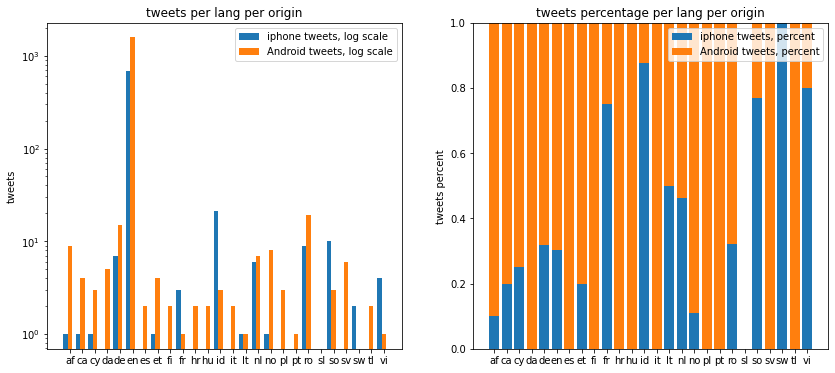


distribution of attribute quote_retweet:


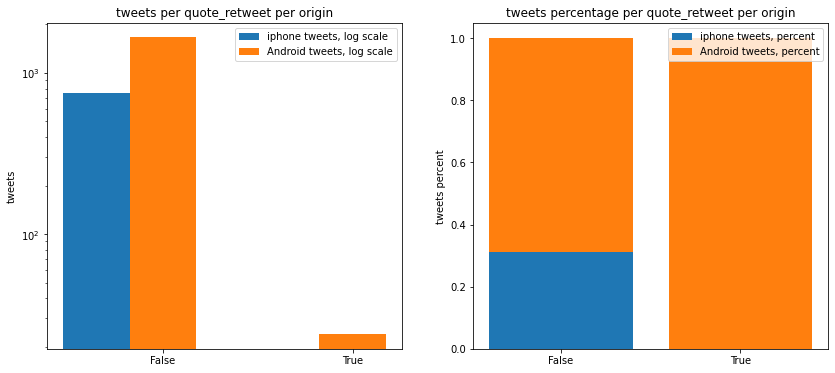


distribution of attribute percent_caps:


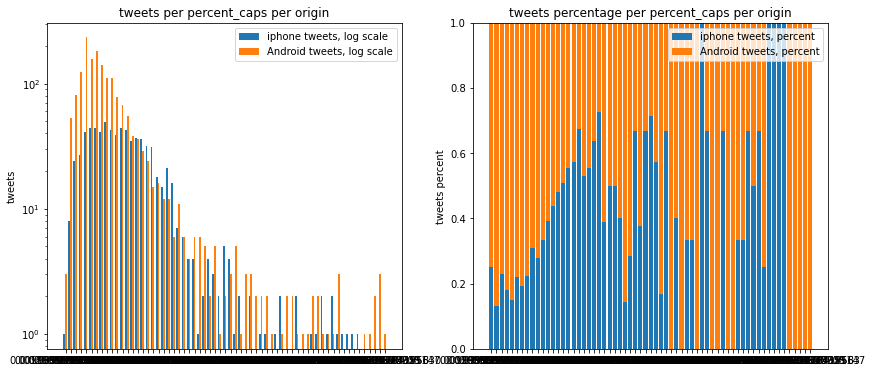


distribution of attribute contains_url:


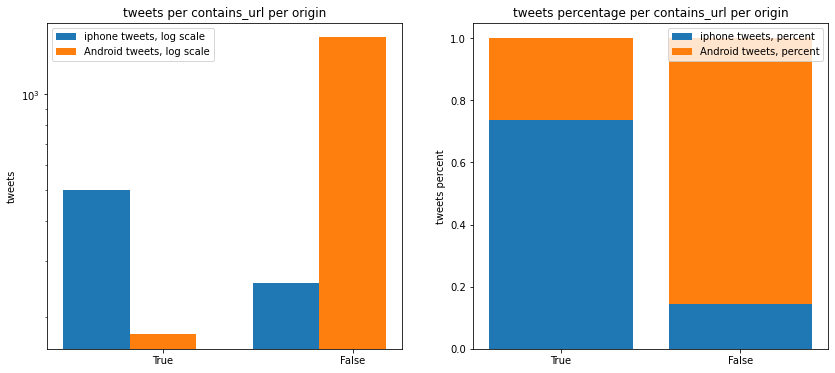


distribution of attribute hashtag_count:


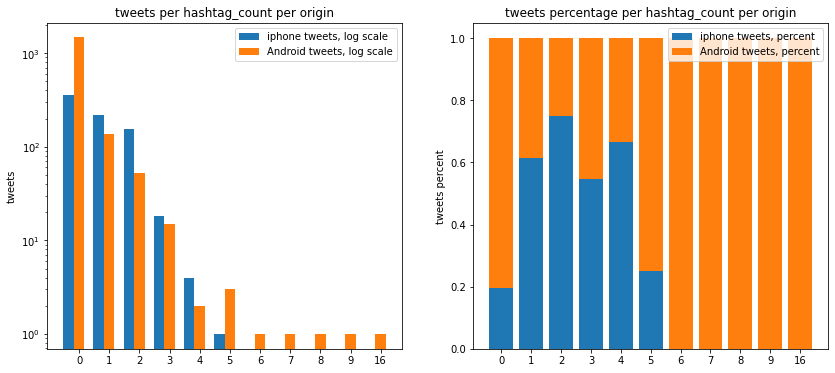


distribution of attribute year:


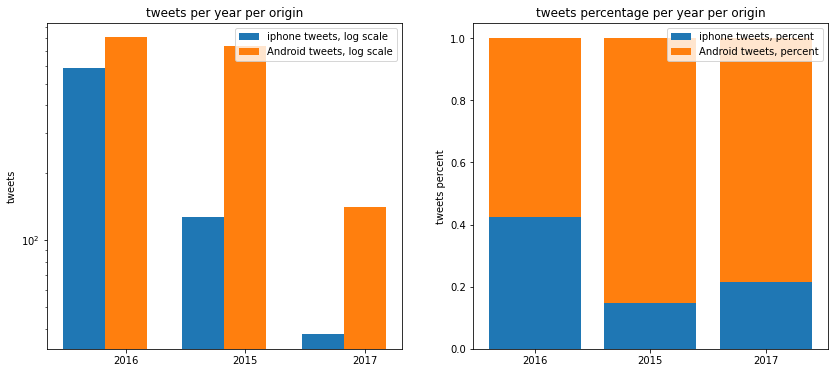


distribution of attribute month:


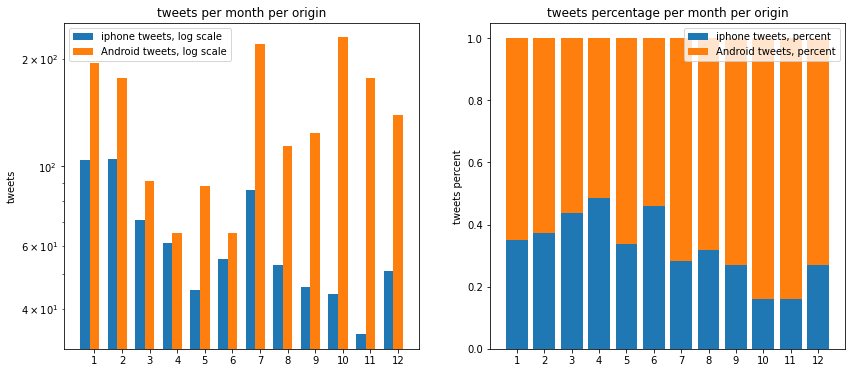


distribution of attribute day:


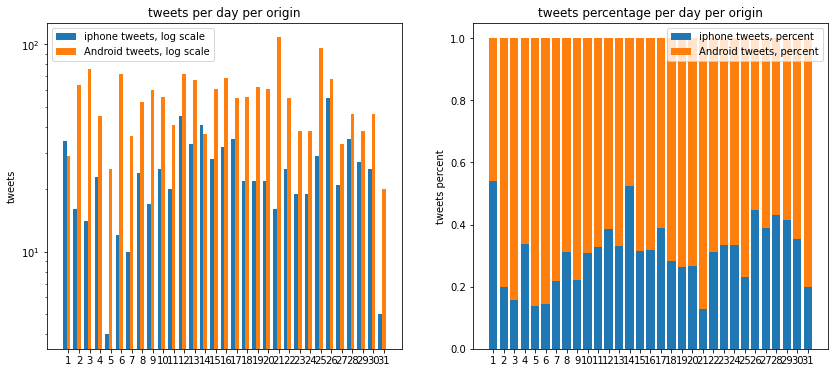


distribution of attribute hour:


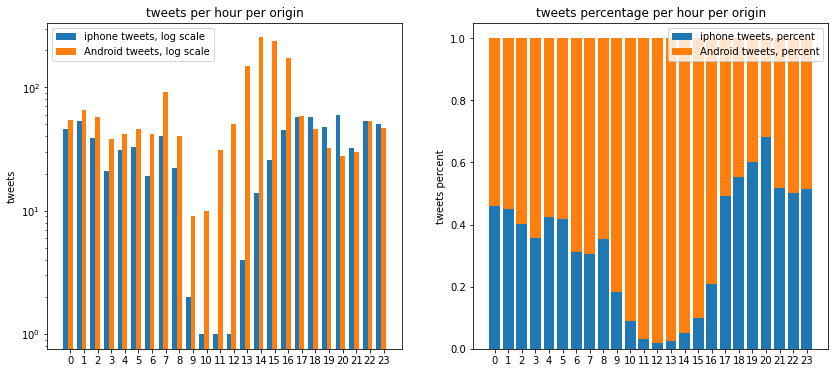


distribution of attribute minute:


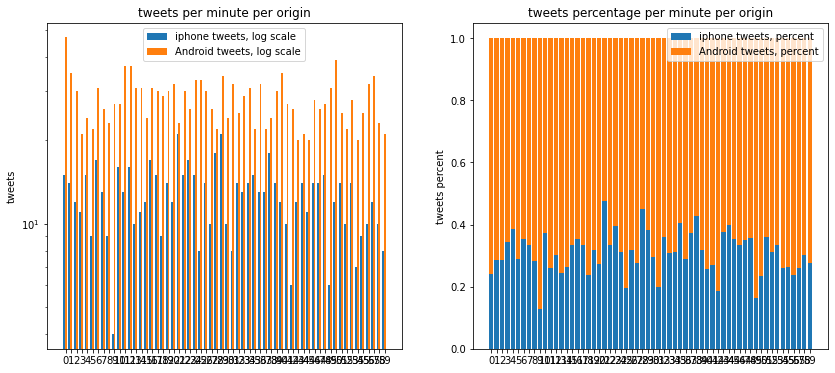


distribution of attribute weekday:


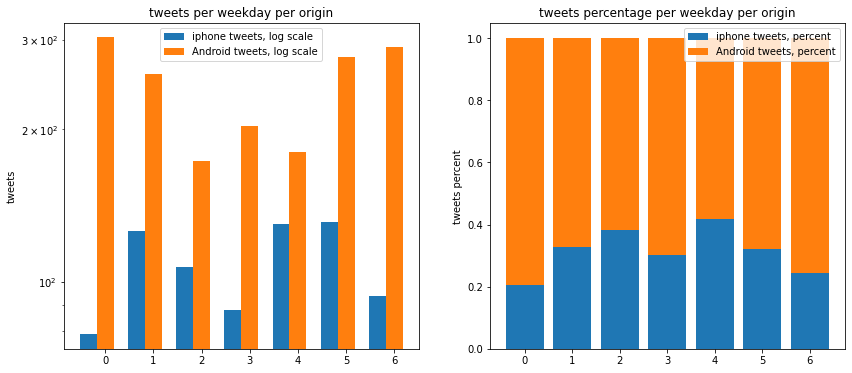

In [26]:
viz_atts = list(data_train.columns)
del viz_atts[0:5]

for attribute in viz_atts:
  print(f'distribution of attribute {attribute}:')

  tweets_per_att_iphone = data_train[data_train.label=='iphone'][attribute].value_counts()
  tweets_per_att_android = data_train[data_train.label=='android'][attribute].value_counts()
  tweets_per_att = pd.concat({'iphone': tweets_per_att_iphone, 'android': tweets_per_att_android}, axis = 1)
  tweets_per_att = tweets_per_att.fillna(0)
  plot_bars(tweets_per_att, attribute)
  print()



# ============================ END of this notebook, below is old stuff

### Preprocess data

#### Run preprocess funnel on train data

In [ ]:
# Reset DF index
if PREPROCESS_TEXT == 'Process':
  articles.index = range(len(articles.index))

##### Compose text for preprocessing

In [ ]:
  if PREPROCESS_TEXT == 'Process':
    preprocessed_data_col = 'data_preprocessed'
    articles[preprocessed_data_col] = articles.title.fillna('') + ' ' + articles.abstract.fillna('') + ' ' + articles.full_text.fillna('')


##### Remove special chars, concurrent spaces, stop words, change to lower case

In [ ]:
# preprocess functions - different for string / series for performance reasons
def preprocess_text(text):
  if type(text) == str:
    en = spacy.load('en_core_web_sm')
    sw_spacy = en.Defaults.stop_words
    stemmer = SnowballStemmer('english').stem

    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    return ' '.join([stemmer(word) for word in text.split() if word not in sw_spacy])
  
  elif type(text) == pd.core.series.Series:
    en = spacy.load('en_core_web_sm')
    sw_spacy = en.Defaults.stop_words
    stemmer = SnowballStemmer('english').stem

    new_series = text.str.translate(str.maketrans('', '', string.punctuation)).str.lower()
    new_series = new_series.progress_apply(lambda txt: ' '.join([stemmer(word) for word in txt.split() if word not in sw_spacy]))

    return new_series
  
  else:
    raise Exception('Invalid type of text: expected string or Series!')


# #Test functions: 
# print(preprocess_text('What.Ever$#         ! The this is International and Drastically nice @'))
# zz = preprocess_text(pd.Series(['What.Ever$#         ! The this is International and Drastically nice @', 
#                                   'What.EverBBB$#         ! The this is International and Drastically nice @']))
# print(zz[0])
# print(zz[1])

In [ ]:
if PREPROCESS_TEXT == 'Process':
  articles[preprocessed_data_col] = preprocess_text(articles[preprocessed_data_col])

##### Save preprocessed data to disk

In [ ]:
if PREPROCESS_TEXT == 'Process':
  data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/20k_top_records_preprocessed.zip')
  articles.to_csv(data_path, index=False, compression='zip') 

#### Load preprocessed data from disk

In [ ]:
if PREPROCESS_TEXT == 'Load':
  data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/20k_top_records_preprocessed.zip')
  articles = pd.read_csv(data_path)

#### Display preprocessed data

In [ ]:
# if PREPROCESS_TEXT != 'Disabled':
articles.head()

### Training: TF/IDF K-means clustering and visualizations

#### Vectorize data

In [ ]:
data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/tfidf_model.pickle')

if RUN_CLUSTERING == 'Process':
  tfidf = TfidfVectorizer(min_df = 5, max_df = 0.95)
  tfidf.fit(articles[preprocessed_data_col])

  with open(data_path, 'wb') as handle:
    pickle.dump(tfidf, handle)

elif RUN_CLUSTERING == 'Load':
  with open(data_path, 'rb') as handle:
    tfidf = pickle.load(handle)


vectorized_data = tfidf.transform(articles[preprocessed_data_col])
print(f'Vectorized data shape: {vectorized_data.shape}')

#### decide on number of clusters for TF/IDF

In [ ]:
if RUN_CLUSTERING == 'Process':
  def kmeans_sse(data, max_k, step):
    # iterate on K value for K-Means and calculate SSE
      iters = range(2, max_k+(step-1), step)
      sse = []
      for k in tqdm(iters):
          sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
      
      return iters, sse


  # Run and plot
  x, sse = kmeans_sse(vectorized_data, 90, 3)
  
  data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/cluster_visualization_x.pickle')
  with open(data_path, 'wb') as handle:
    pickle.dump(x, handle)
  
  data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/cluster_visualization_sse.pickle')
  with open(data_path, 'wb') as handle:
    pickle.dump(sse, handle)


elif RUN_CLUSTERING == 'Load':
  data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/cluster_visualization_x.pickle')
  with open(data_path, 'rb') as handle:
    x = pickle.load(handle)
  
  data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/cluster_visualization_sse.pickle')
  with open(data_path, 'rb') as handle:
    sse = pickle.load(handle)


f, ax = plt.subplots(1, 1)
f.set_size_inches(10, 10)
ax.plot(x, sse, marker='o')
ax.set_xlabel('Cluster Centers')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_ylabel('SSE')
ax.set_title('SSE by Cluster Center Plot')

#### Cluster data and plot results in 2D

In [ ]:
data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/kmeans_model.pickle')

if RUN_CLUSTERING == 'Process':
  N_CLUSTERS = 16 # number of clusters selected
  kmeans_model = MiniBatchKMeans(n_clusters=N_CLUSTERS, init_size=1024, batch_size=2048, random_state=20).fit(vectorized_data)

  with open(data_path, 'wb') as handle:
    pickle.dump(kmeans_model, handle)

elif RUN_CLUSTERING == 'Load':
  with open(data_path, 'rb') as handle:
    kmeans_model = pickle.load(handle)


# add clusters to dataframe
clusters = kmeans_model.predict(vectorized_data)
articles['cluster'] = clusters

In [ ]:
def plot_tsne_pca(data, labels):
    NUM_SAMPLES = 10000
    max_label = max(labels)
    samples = np.random.choice(range(data.shape[0]), size=NUM_SAMPLES, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[samples,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[samples,:].todense()))
    
    idx = np.random.choice(range(pca.shape[0]), size=NUM_SAMPLES, replace=False)
    label_subset = labels[samples]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(22, 10))

    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset, s=1)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset, s=1)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(vectorized_data, clusters)

### Inference - similar text finder

#### Inference function for similar text lookup

In [ ]:
def find_similar_texts(input_text, preprocessed_corpus, num_results, tfidf_model, kmeans_model):
  preprocessed_data_col = 'data_preprocessed'

  # preprocess input text
  input_text_prep = preprocess_text(input_text)

  # wrap input text in pandas for use with similarity function
  input_text_df = pd.DataFrame([['Input', input_text_prep]], columns=['cord_uid', preprocessed_data_col])

  # vectorize input text
  input_text_vectorized = tfidf_model.transform([input_text_prep])
  print(f'Vectorized data shape: {input_text_vectorized.shape}')

  # find cluster for input text sample
  input_cluster = kmeans_model.predict(input_text_vectorized)[0]
  print (f'Input cluster: {input_cluster}')

  # find docs with same cluster as input
  relevant_cluster_articles = articles[articles.cluster == input_cluster]

  # find N most similar docs withion cluster
  top_similar_docs = k_similar_documents(relevant_cluster_articles, preprocessed_data_col, input_text_df.loc[0], num_results)

  results = articles[articles['cord_uid'].isin(top_similar_docs[0])].copy()
  results['ncd_distance'] = top_similar_docs[1]
  return results



#### Test

In [ ]:
# input_text = articles.full_text[35]
tfidf_model = tfidf


input_text = '''
  ary to evaluate the effect of anti-epidemic bonds to stimulate market vitality and achieve the epidemic control goal as soon as possible. Nozawa and Qiu (2021) document that the 
  rising default risk of firms that face cash shortfalls due to the outbreak is a key concern among the major issues facing the economy; thus, liquidity support offered by anti-epidemic 
  bonds can mitigate risk and instill confidence in the market. Based on the above, our study focuses on a nascent rise in anti-epidemic bonds in China and examines the stock market reaction 
  of anti-epidemic bonds. First, we calculate the abnormal s the COVID-19 pandemic mainly focuses on quantitative easing monetary policy (O'Hara and Zhou, 2021; D'Amico et al., 2020; Nozawa and Qiu, 2021) . 
   This paper contributes to the nascent literature by exploiting the market-based epidemic control policy in the largest developing economy, which also suffers the outbreak first. This paper also complements international findings 
   about stock market reactions to special bonds, such as green bonds (Wang et al., 2020) , and new perspectives about bond spillover effects on the stock market (Reboredo , 2018) by dissecting stock market reactions to anti-epidemic bond 
   issuance announcements. Determined by the issuance of the first anti-epidemic corporate bond in February 2020, the antiepidemic corporate bond sample data are from February 2020 to December 2021. We collect all bond data with an anti-epidemic 
   flag and match the bond characteristics, firm information and stock trading data from the Wind database. The initial anti-epidemic bond sample comprises 800 bonds. To examine the reaction of the stock market, we focus on bonds issued by listed 
   companies in the Chinese stock market. There are 179 anti-epidemic bonds issued by 122 listed corporates among the initial sample. For these anti-epidemic bond issuers, we extract all conventional bond issuance announcements from 2018 to 2021 and then 
   delete convertible bonds, exchangeable bonds, subordinated bonds, commercial bank bonds and nt date of a bond issue (t=0) and use [-5, 5] as the event window. We calculate cumulative abnormal return
     (CAR) using a market model (with Shanghai and Shenzhen 300 index as the market factor). The average abnormal return (AAR) and cumulative abnormal return (CAR) are calculated based on the existing literature 
     c productivity and global resource efficiency, strengthening the capacity of domestic financial institutions and promoting aspects of SDG 8. Two papers address monitoring and measurement of SDG 8, i.e. the development 
     of a proposal for new sub-goals, targets and indicators from a degrowth perspective and the development of a nowcasting approach for indicators assigned to SDG 8. Other aspects addressed in this special issue include an assessment of the 
     potential of different labor market policies for greening employment and an econometric analysis at the intersection of SDG 8 with energy efficiency (SDG 7), technological change (SDG 9) and climate change (SDG 13) that focuses on the
      determinants and effects of the adoption of "green energy saving and related technologies" (GETs). In the first paper of this special issue, Kreinin and Aigner (2021) propose  The authors analyze the goal from 
      the perspective of "strong sustainability" (e.g. Ayres et al. 2001 ) and provide a reformulated framework including new sub-goals, targets and indicators, which they argue being better in line with the overall goals of the SDGs and the 
      Agenda 2030. In their work, they peel out and discuss aspects of SDG 8 which are currently interfering the idea of long-term social-ecological sustainability. Their approach differentiates itself more clearly from economic growth and
       productivity per se and rather focuses on aspects of social and environmental well-being, decency of work and dependence of economic growth and unsustainable work. Evaluating the progress of the SDGs provides important information for policy
'''


In [ ]:
find_similar_texts(input_text, articles, 5, tfidf_model, kmeans_model)


# Experiments and snippets

In [ ]:
# # Calculate compressed doc length

# num_articles = len(articles)

# data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/doc_compressed_len.npy')
# if data_path.is_file():
#   doc_compressed_len = np.load(data_path)

# else:
#   # Compress each document by its own, store length of compression
#   print('Calculating compressed len per document:')
#   doc_compressed_len = np.zeros(num_articles, dtype='int16')
  
#   with tqdm(total = len(articles)) as progress_bar:
#     for x, article_x in articles.iterrows():
#       doc_compressed_len[x] = len(gzip.compress(article_x['full_text'].encode()))
#       progress_bar.update(1)
  
#   data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/doc_compressed_len.npy')
#   np.save(data_path, doc_compressed_len)



In [ ]:
# # Calculate distance matrix

# print('Calculating distance matrix:')
# data_path = Path('/content/drive/MyDrive/colab_data/aml_hw3/data/ncd_dist_matrix.npy')
# if data_path.is_file():
#   ncd_dist_matrix = np.load(data_path)
# else:
#   ncd_dist_matrix = np.zeros([num_articles, num_articles], dtype='float64')   # needed first time only

# new_data_calculated = False

# with tqdm(total = len(articles)) as progress_bar:
#   for x, article_x in articles.iterrows():   
#     for y, article_y in articles.iterrows():     
#       if ((x <= y) and ncd_dist_matrix[x, y] == 0):
#         x_y_compressed = gzip.compress((article_x['full_text'] + article_y['full_text']).encode())
      
#         ncd_dist_matrix[x, y] = (len(x_y_compressed) - min(doc_compressed_len[x], doc_compressed_len[y])) / max(doc_compressed_len[x], doc_compressed_len[y])
#         ncd_dist_matrix[y, x] = ncd_dist_matrix[x, y]
#         new_data_calculated = True
  
#     if (new_data_calculated and (x % 10 == 0)):
#       np.save(data_path, ncd_dist_matrix)

#     progress_bar.update(1)


In [ ]:
##################################################################

In [ ]:
# def calc_doc_distance(x, y):
#   x_compressed = gzip.compress(x['full_text'].encode())
#   y_compressed = gzip.compress(y['full_text'].encode())
#   x_y_compressed = gzip.compress((x['full_text'] + y['full_text']).encode())
  
#   ncd = (len(x_y_compressed) - min(len(x_compressed), len(y_compressed))) / max(len(x_compressed), len(y_compressed))
#   return ncd

In [ ]:
# calc_doc_distance(articles.loc[220], articles.loc[220])